In [1]:
# %load_ext cudf.pandas
# %load_ext cuml.accel
!pip install --upgrade -qq shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.3 MB/s eta 0:00:00


In [2]:
import torch
import sys
import os
import gc

import joblib
import pickle

## -- DATA MANIPUALATION --
import numpy as np
import pandas as pd
import random

## -- VISUALISATION --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shap

## -- FUNCTIONAL TOOLS --
from google.colab import files
from itertools import combinations
from tqdm.notebook import tqdm
from time import time

# ## SCIKIT-LEARN
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector as SFS1
from mlxtend.feature_selection import SequentialFeatureSelector as SFS2

# -- GBDTs --
import xgboost as xgb
import lightgbm as lgb
try:
    import catboost as cgb
except:
    %pip install -qq -U catboost
    import catboost as cgb

import warnings

In [3]:
##### --- GLOBAL SETTINGS --- #####
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', None)
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Set Global Seed --
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## -- Set Device-Agnostic code --
USE_cud = "cuda" if torch.cuda.is_available() else "cpu"
USE_gpu = "gpu" if torch.cuda.is_available() else "cpu"
USE_GPU = "GPU" if torch.cuda.is_available() else "CPU"

COLOR = '\033[36m'
RESET = '\033[0m'

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

In [4]:
PATH       = "/kaggle/input/playground-series-s5e9/"
train      = pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test       = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)

orig = pd.read_csv("/kaggle/input/bpm-prediction-challenge/Train.csv")
orig['id'] = np.arange(len(orig))
orig.set_index('id', inplace=True)

submit     = pd.read_csv(PATH+"sample_submission.csv")

TARGET     = 'BeatsPerMinute'
FEATURES   = test.columns.tolist()

In [5]:
display(train.head())
train.info()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


<class 'pandas.core.frame.DataFrame'>
Index: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                524164 non-null  float64
 1   AudioLoudness              524164 non-null  float64
 2   VocalContent               524164 non-null  float64
 3   AcousticQuality            524164 non-null  float64
 4   InstrumentalScore          524164 non-null  float64
 5   LivePerformanceLikelihood  524164 non-null  float64
 6   MoodScore                  524164 non-null  float64
 7   TrackDurationMs            524164 non-null  float64
 8   Energy                     524164 non-null  float64
 9   BeatsPerMinute             524164 non-null  float64
dtypes: float64(10)
memory usage: 44.0 MB


In [6]:
display(test.head())
test.info()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
id,,,,,,,,,
524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067
524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467
524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067


<class 'pandas.core.frame.DataFrame'>
Index: 174722 entries, 524164 to 698885
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                174722 non-null  float64
 1   AudioLoudness              174722 non-null  float64
 2   VocalContent               174722 non-null  float64
 3   AcousticQuality            174722 non-null  float64
 4   InstrumentalScore          174722 non-null  float64
 5   LivePerformanceLikelihood  174722 non-null  float64
 6   MoodScore                  174722 non-null  float64
 7   TrackDurationMs            174722 non-null  float64
 8   Energy                     174722 non-null  float64
dtypes: float64(9)
memory usage: 13.3 MB


In [7]:
display(orig.head())
orig.info()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
id,,,,,,,,,,
0,0.513080,-7.811659,0.071013,0.064564,0.109495,0.316042,0.736929,328639.3188,0.556200,117.092439
1,0.775393,-6.819409,0.023500,0.510599,0.187498,0.024361,0.259488,271967.9826,0.410533,122.002279
2,0.636408,-19.782248,0.063451,0.427861,0.002226,0.024300,0.054848,186147.0029,0.533333,149.130616
3,0.232190,-14.957299,0.023500,0.076268,0.000001,0.228454,0.744650,321734.9723,0.658533,95.832178
4,0.758564,-4.715966,0.023500,0.263551,0.414794,0.197167,0.966592,179973.3982,0.230467,125.696263


<class 'pandas.core.frame.DataFrame'>
Index: 14633 entries, 0 to 14632
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RhythmScore                14633 non-null  float64
 1   AudioLoudness              14633 non-null  float64
 2   VocalContent               14633 non-null  float64
 3   AcousticQuality            14633 non-null  float64
 4   InstrumentalScore          14633 non-null  float64
 5   LivePerformanceLikelihood  14633 non-null  float64
 6   MoodScore                  14633 non-null  float64
 7   TrackDurationMs            14633 non-null  float64
 8   Energy                     14633 non-null  float64
 9   BeatsPerMinute             14633 non-null  float64
dtypes: float64(10)
memory usage: 1.2 MB


In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
RhythmScore,524164.0,0.632843,0.156899,0.076900,0.515850,0.634686,0.739179,0.975000
AudioLoudness,524164.0,-8.379014,4.616221,-27.509725,-11.551933,-8.252499,-4.912298,-1.357000
VocalContent,524164.0,0.074443,0.049939,0.023500,0.023500,0.066425,0.107343,0.256401
AcousticQuality,524164.0,0.262913,0.223120,0.000005,0.069413,0.242502,0.396957,0.995000
InstrumentalScore,524164.0,0.117690,0.131845,0.000001,0.000001,0.074247,0.204065,0.869258
LivePerformanceLikelihood,524164.0,0.178398,0.118186,0.024300,0.077637,0.166327,0.268946,0.599924
MoodScore,524164.0,0.555843,0.225480,0.025600,0.403921,0.564817,0.716633,0.978000
TrackDurationMs,524164.0,241903.692949,59326.601501,63973.000000,207099.876625,243684.058150,281851.658500,464723.228100
Energy,524164.0,0.500923,0.289952,0.000067,0.254933,0.511800,0.746000,1.000000
BeatsPerMinute,524164.0,119.034899,26.468077,46.718000,101.070410,118.747660,136.686590,206.037000


In [9]:
# Check if column names are the same regardless of order
are_same_set = set(train.columns) == set(orig.columns)
print(f"Are column names the same regardless of order (train vs orig)? {are_same_set}")

# Check if column names are exactly the same and in the same order
are_same_exact = train.columns.equals(orig.columns)
print(f"Are column names exactly the same and in the same order (train vs orig)? {are_same_exact}")

Are column names the same regardless of order (train vs orig)? True
Are column names exactly the same and in the same order (train vs orig)? True


In [10]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in test.columns:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='Spectral')

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
Train,322528,310411,229305,270478,218979,279591,306504,377442,11606
Original,14354,13311,10892,11833,9435,12283,13689,14567,14633
Test,116151,110402,84370,97364,79221,101149,109993,133624,10465


In [11]:
def distplots_data(
                    train: pd.DataFrame,
                    test: pd.DataFrame,
                    orig: pd.DataFrame,
                    features: list[str]):

    df = pd.concat([train[features].assign(Source = 'Train'), 
                    test[features].assign(Source = 'Test'),
                    orig[features].assign(Source = 'Original'),], 
                    axis=0, ignore_index = True)

    fig, axs = plt.subplots(len(features), 2 ,figsize = (18, len(features) * 5), 
                            gridspec_kw = {
                                            'hspace': 0.2, 
                                            'wspace': 0.15, 
                                            'width_ratios': [0.7, 0.3]
                                    }
                    )
    PALETTE = ['g', 'r', 'orange']
    for i, col in enumerate(features):
        ax = axs[i, 0]
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                    palette = PALETTE, ax = ax, linewidth = 2
                   )
        ax.set(xlabel = '', ylabel = '')
        ax.set_title(f"\n{col}")
        ax.grid()

        ax = axs[i, 1]
        sns.boxplot(data = df, y=col, x=df['Source'], width = 0.5,
                    linewidth = 1, fliersize= 1,
                    ax = ax, palette = PALETTE
                   )
        ax.set_title(f"\n{col}")
        ax.set(xlabel = '', ylabel = '')
        ax.tick_params(axis='both', which='major')
        ax.set_xticklabels(['Train', 'Test', 'Original'])

    plt.tight_layout()
    plt.show()


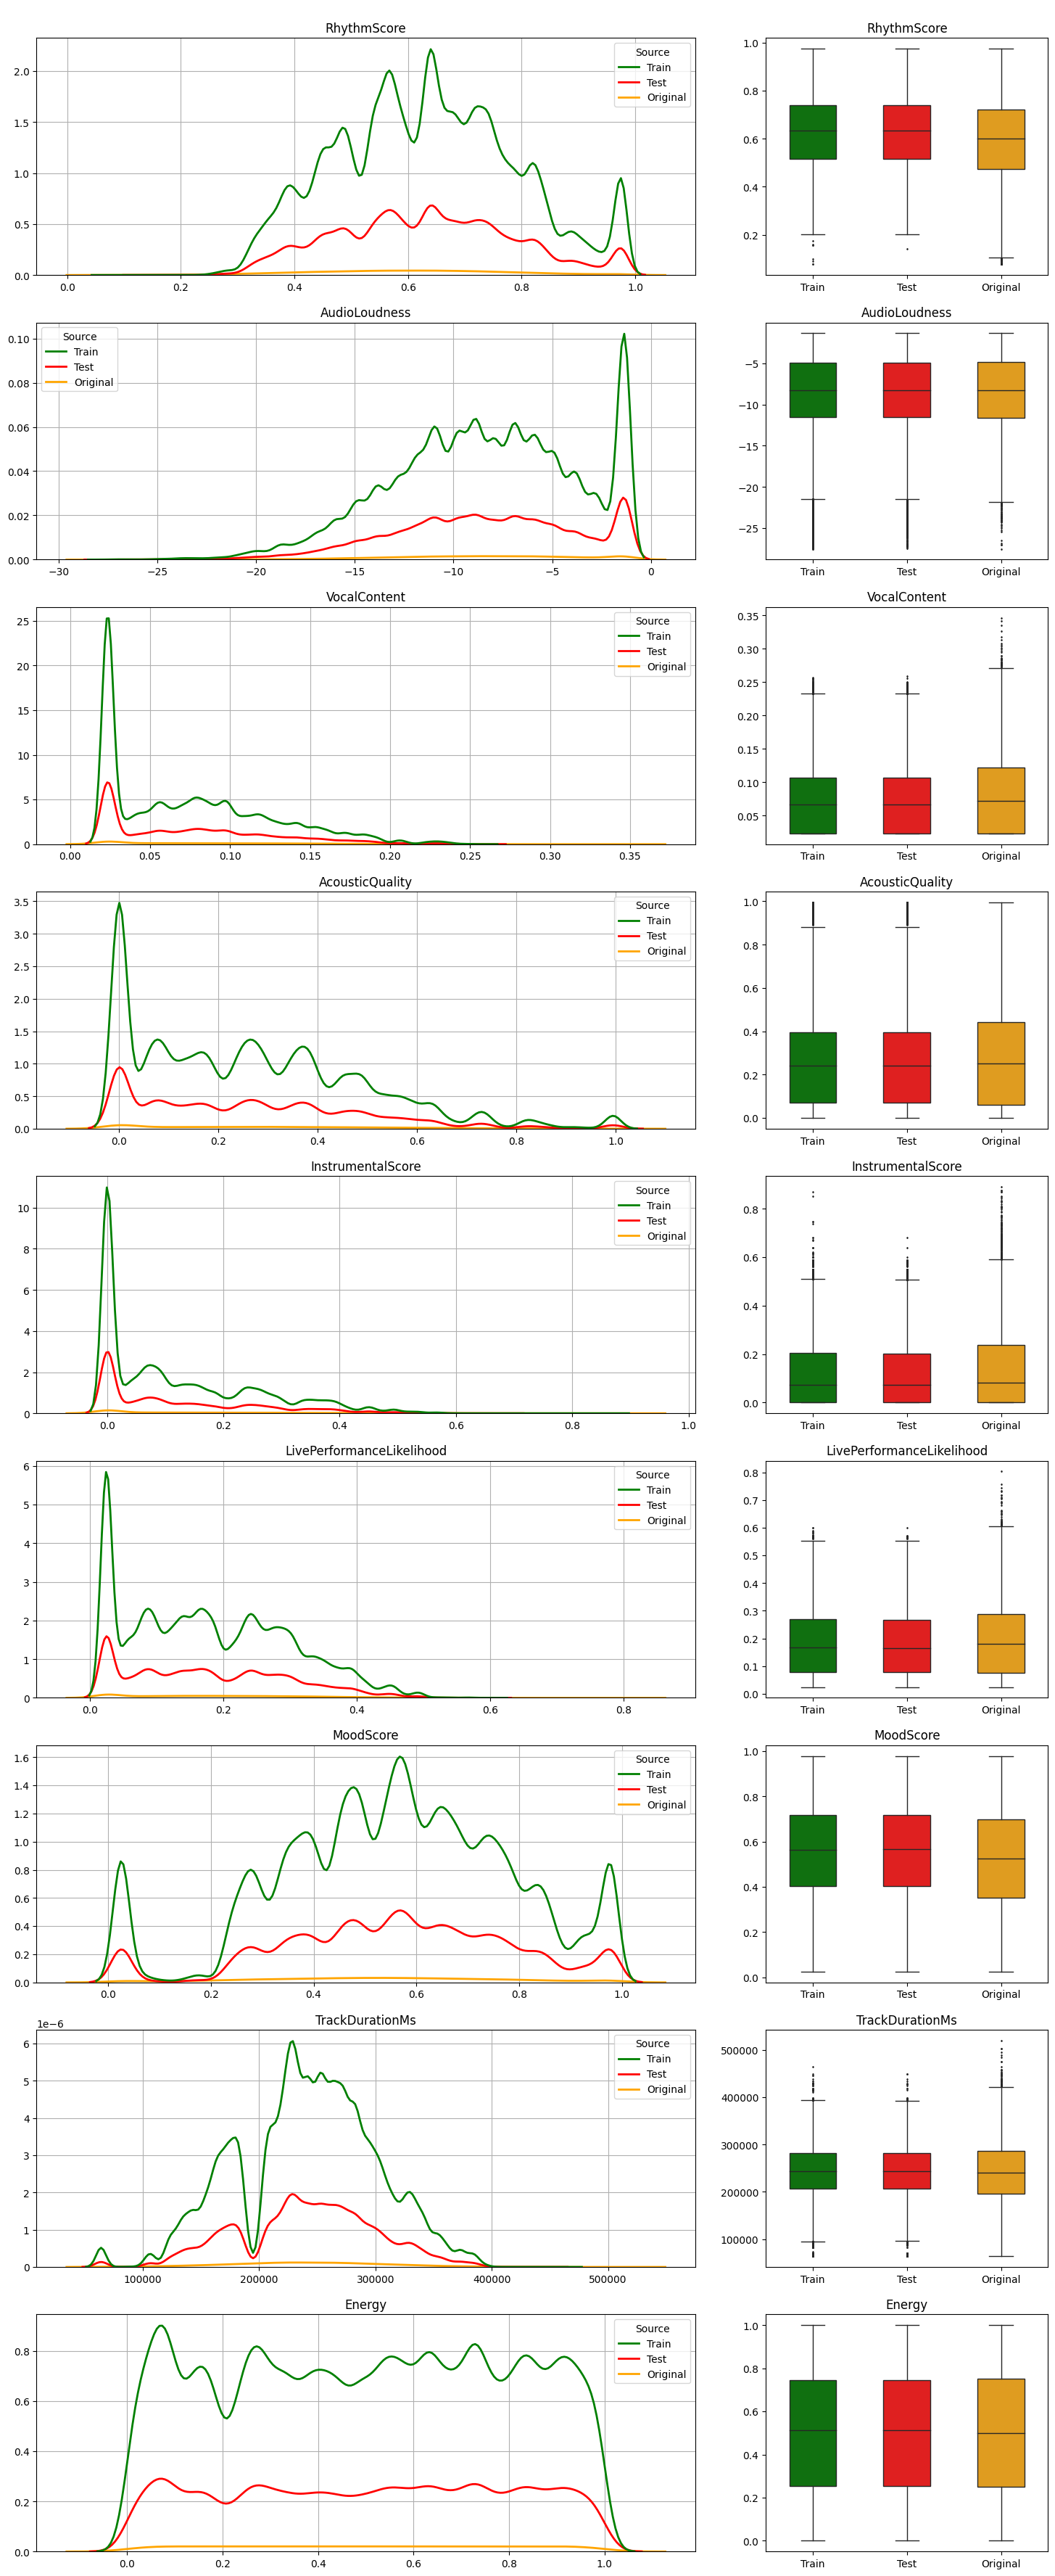

In [12]:
distplots_data(train, test, orig, FEATURES)

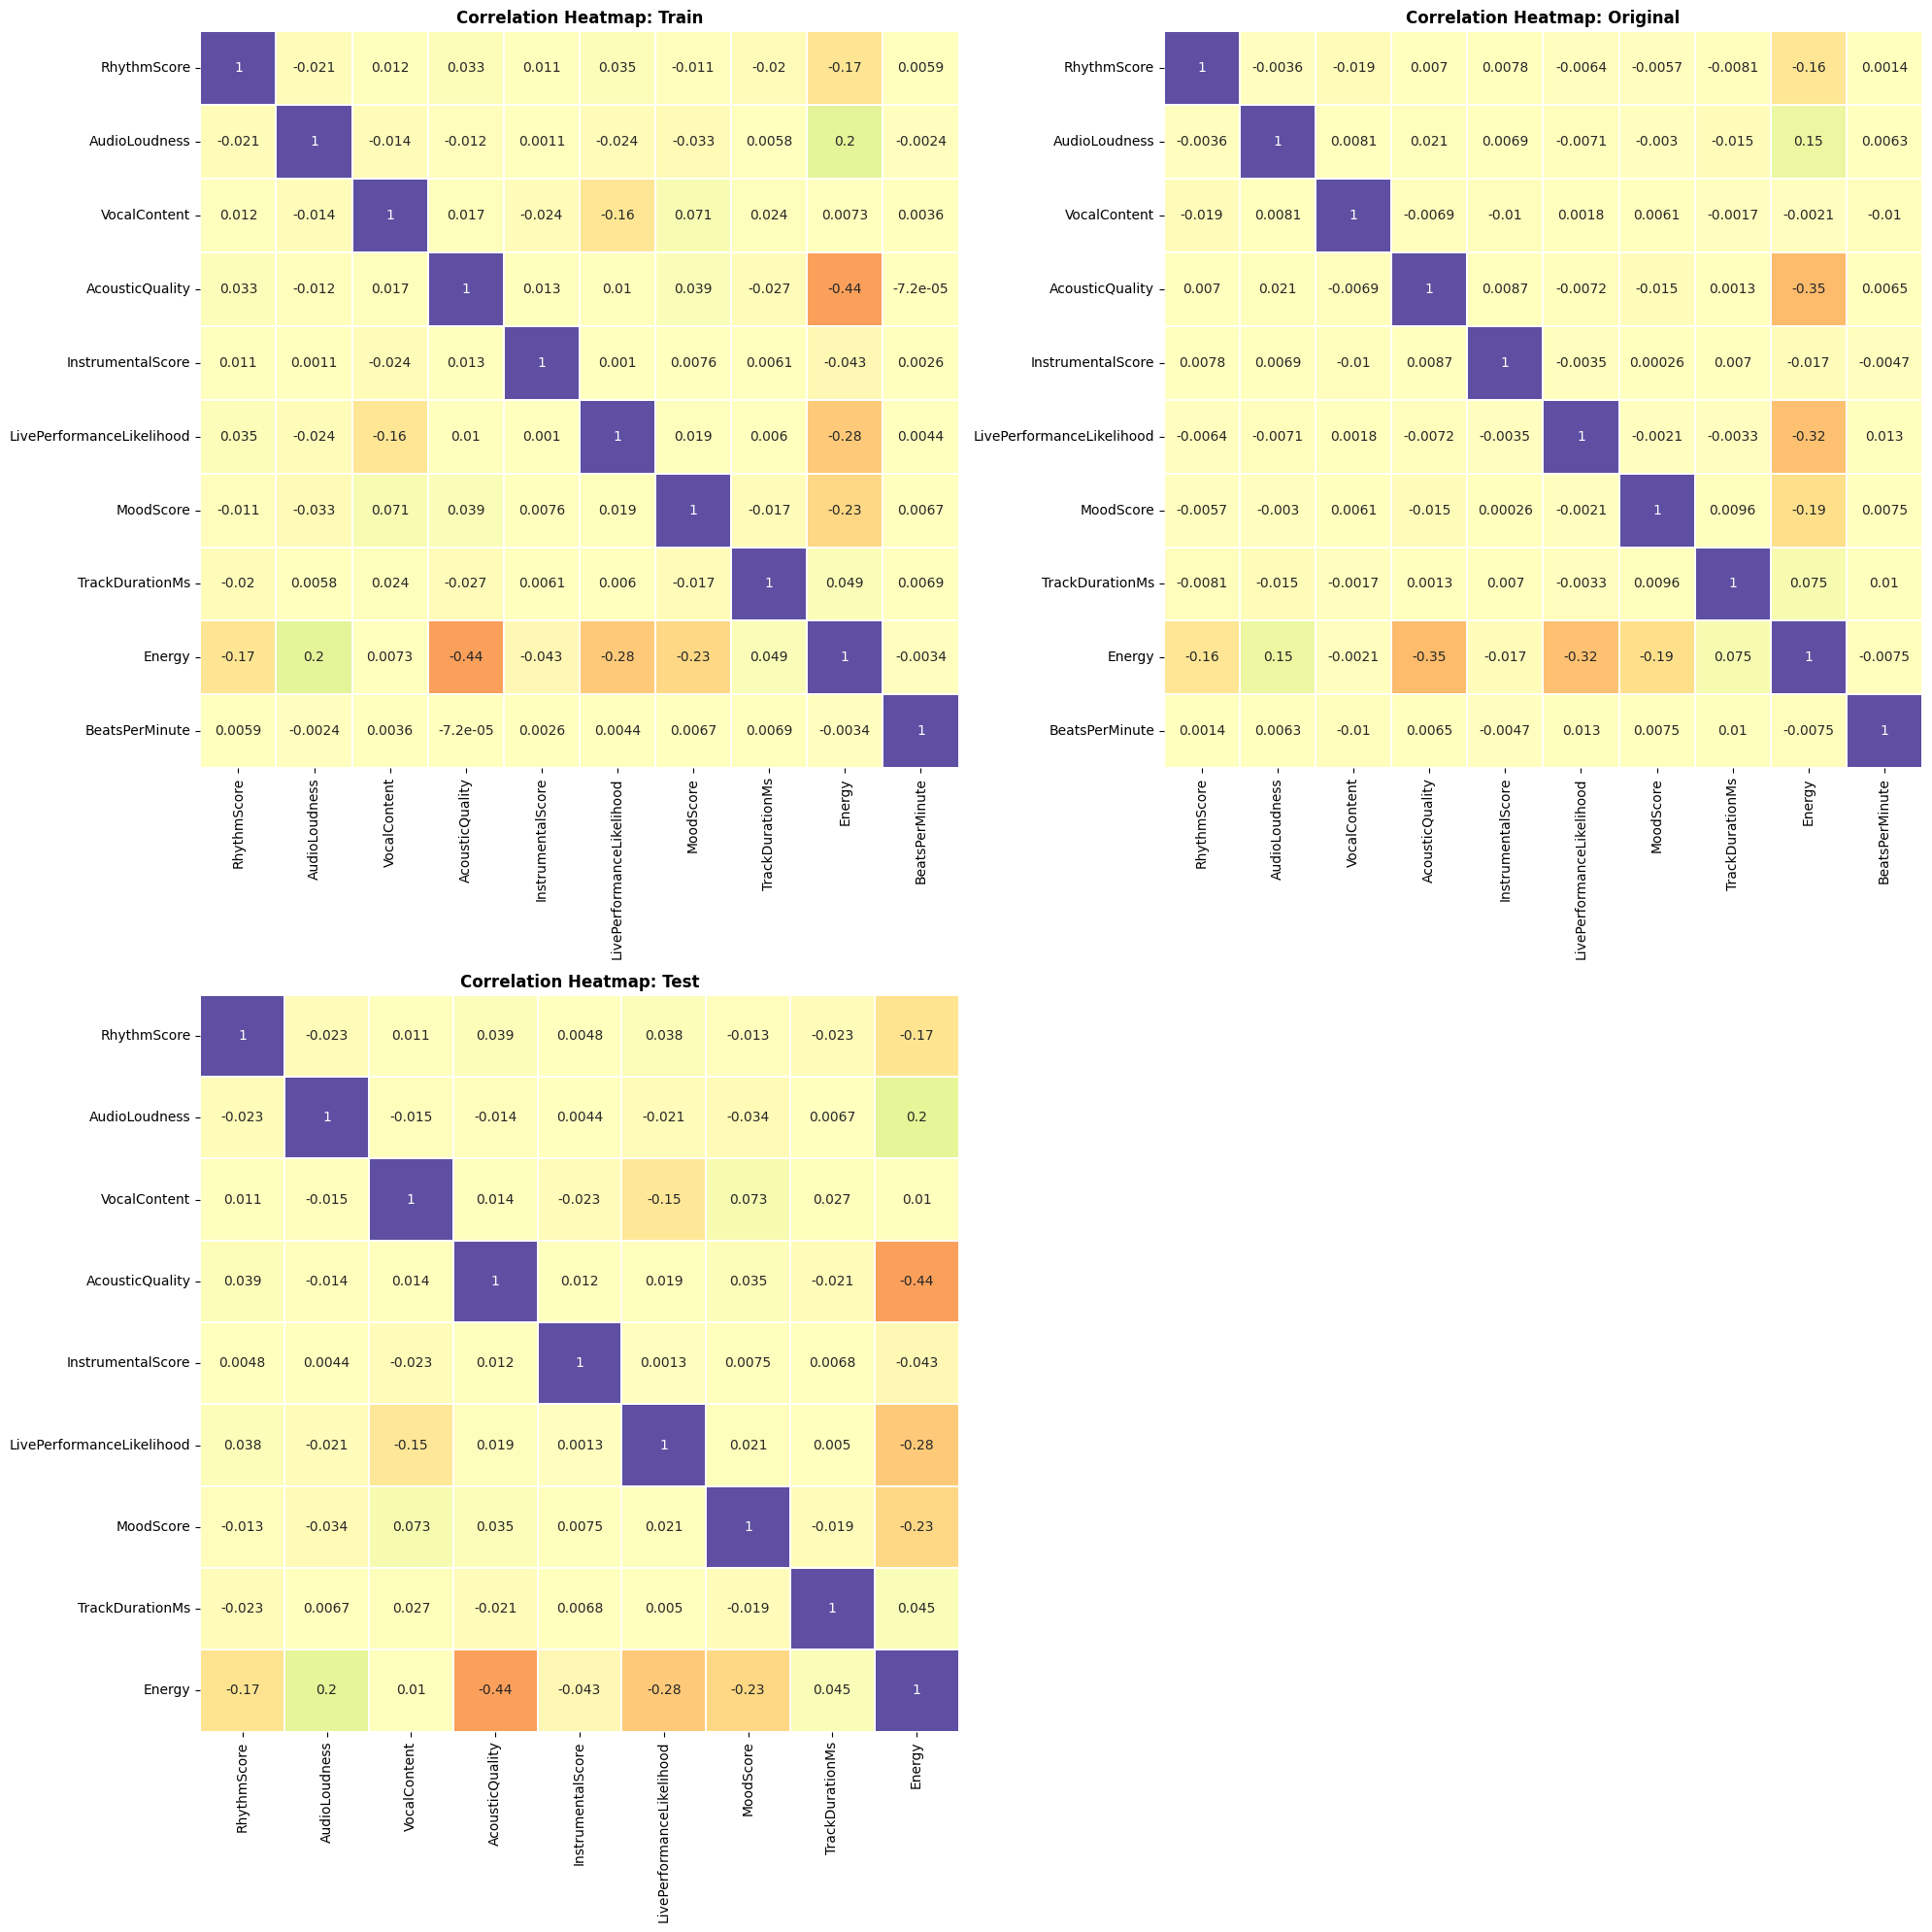

In [13]:
df_names = ['Train', 'Original', 'Test']
plt.figure(figsize=(20, 20))
for i, df in enumerate([train,orig,test]):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(
            data=df.corr('spearman'), cmap='Spectral',
            annot=True, center=0, linewidths=0.1, cbar=False,
        )
    plt.xticks(rotation=90)
    plt.title(f"Correlation Heatmap: {df_names[i]}", fontweight='semibold')

plt.tight_layout()
plt.show()

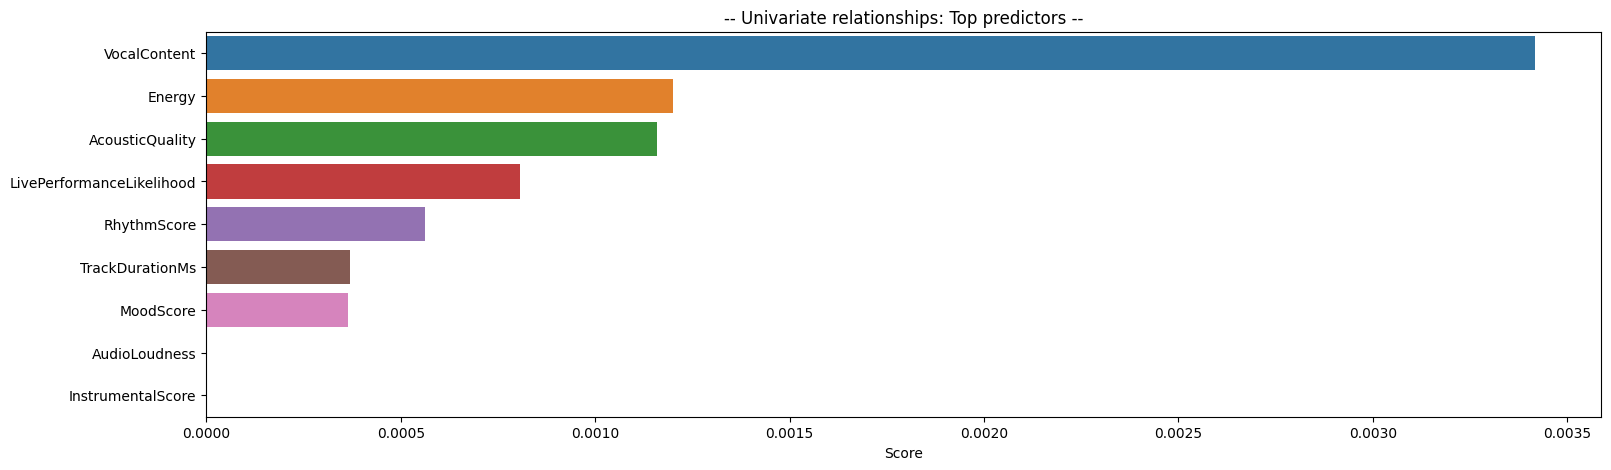

CPU times: user 1min 18s, sys: 86.3 ms, total: 1min 18s
Wall time: 1min 18s


In [14]:
%%time
## -- Mutual Info: Features vs Target --
mutual_info = mutual_info_regression(train[FEATURES], train[TARGET], random_state=SEED)
mutual_info_df = pd.DataFrame.from_dict(
    dict(zip(FEATURES, list(mutual_info))), orient='index', columns=['Score'])\
    .sort_values(by='Score', ascending=False)

plt.figure(figsize=(18, 5))
sns.barplot(data=mutual_info_df, x='Score', y=mutual_info_df.index)
plt.title("-- Univariate relationships: Top predictors --")
plt.show()

### PROFILE REPORT

In [15]:
# %%capture
# # -- Comprehensive EDA --
# !{sys.executable} -m pip install -U ydata-profiling[notebook]
# !pip install jupyter-contrib-nbextensions
# !jupyter nbextension enable --py widgetsnbextension

# from ydata_profiling import ProfileReport, compare

# ## -- Single EDA --
# profile_df = ProfileReport(train, title="Insights into y Types", explorative=True)
# profile_df.to_notebook_iframe()

# profile_df.to_file("Beats_EDA_Report.html")

# ## -- Create Pofiles for Datasets --
# train_report = ProfileReport(train, title="Train")
# test_report = ProfileReport(test, title="Test")
# orig_report = ProfileReport(orig, title="Original")

## -- Compare 2 Datasets --
# comparison_report = train_report.compare(orig_report)

# comparison_report.to_notebook_iframe()

# comparison_report = train_report.compare(test_report)
# comparison_report.to_notebook_iframe()

# comparison_report.to_file("Beats_Comparison_EDA_Report.html")

## -- Compare 2++ Datasets --
# comparison_report = compare([train_report, orig1_report])

# Obtain merged statistics
# statistics = comparison_report.get_description()
# Save report to file
# comparison_report.to_file("Train_Orig_Comparisons.html")
# comparison_report

# ML TRAINING

In [16]:
## -- DEFINE MODELS -- ##
models = {
    'XGB': xgb.XGBRegressor(#**xgb_0,
        eval_metric='rmse', random_state=SEED,
        n_estimators=100, #learning_rate=0.05, max_depth=0,
        # reg_alpha=2.5, reg_lambda=1.0, min_child_weight=1.5, 
        # # subsample=0.85, colsample_bytree=0.5, colsample_bynode=0.5,
        # early_stopping_rounds=50, # enable_categorical=True,
        verbosity=0, n_jobs=-1, device=USE_cud,
    ),
    'LGBM': lgb.LGBMRegressor(#**lgb_1,
        metric='rmse', random_state=SEED, device=USE_gpu,
        n_estimators=100, #learning_rate=0.02, max_depth=8,
        # reg_alpha=1.5, reg_lambda=1.0, min_child_weight=1.5,
         n_jobs=-1, verbose=-1, 
    ),
    'CAT': cgb.CatBoostRegressor(#**cgb_0,
        eval_metric='RMSE', random_state=SEED, task_type=USE_GPU,
        allow_writing_files=False, thread_count=-1, verbose=0,
        n_estimators=100, #learning_rate=0.02, depth=8, 
        l2_leaf_reg=0.001, #min_child_samples=1.5, cat_features=cat_cols,
    ),
    'HGB': HistGradientBoostingRegressor(#**hist_0,
        scoring='neg_root_mean_squared_error', random_state=SEED,
        max_iter=100, #learning_rate=0.005, max_depth=6,
        # l2_regularization=0.01, n_iter_no_change=200,
        # verbose=0, # categorical_features=cat_cols, 
    ),
    # 'RF': RandomForestRegressor(
    #     n_estimators=100, #max_depth=8,
    #     random_state=SEED, n_jobs=-1
    # ),
    # 'Logistic': LogisticRegression(#**logit_0,
    #     max_iter = 2000, random_state = SEED, n_jobs=-1,
    #  ),
    # 'nn_MLP': MLPRegressor(#**mlp_0,
    #     alpha=0.01, max_iter=1000,
    #     # hidden_layer_sizes=(128, 64),
    #     # n_iter_no_change=100, random_state=SEED,
    #  ),
}

print(f"Number of models: {len(models)}")
print(models.keys())

Number of models: 4
dict_keys(['XGB', 'LGBM', 'CAT', 'HGB'])


TRAINING MODELS:   0%|          | 0/4 [00:00<?, ?it/s]


[1] XGB ████████████████████████████████████████
	Fold 1 RMSE: 26.552578
	Fold 2 RMSE: 26.544512
	Fold 3 RMSE: 26.612320
	Fold 4 RMSE: 26.573030
	Fold 5 RMSE: 26.624070
	Fold 6 RMSE: 26.625192
	Fold 7 RMSE: 26.538978
	Fold 8 RMSE: 26.530981
	Fold 9 RMSE: 26.514277
	Fold 10 RMSE: 26.510629
|----------------------------------------------------
|  Overall OOF RMSE: 26.562689
| Average Fold RMSE: 26.562657 ± 0.041592


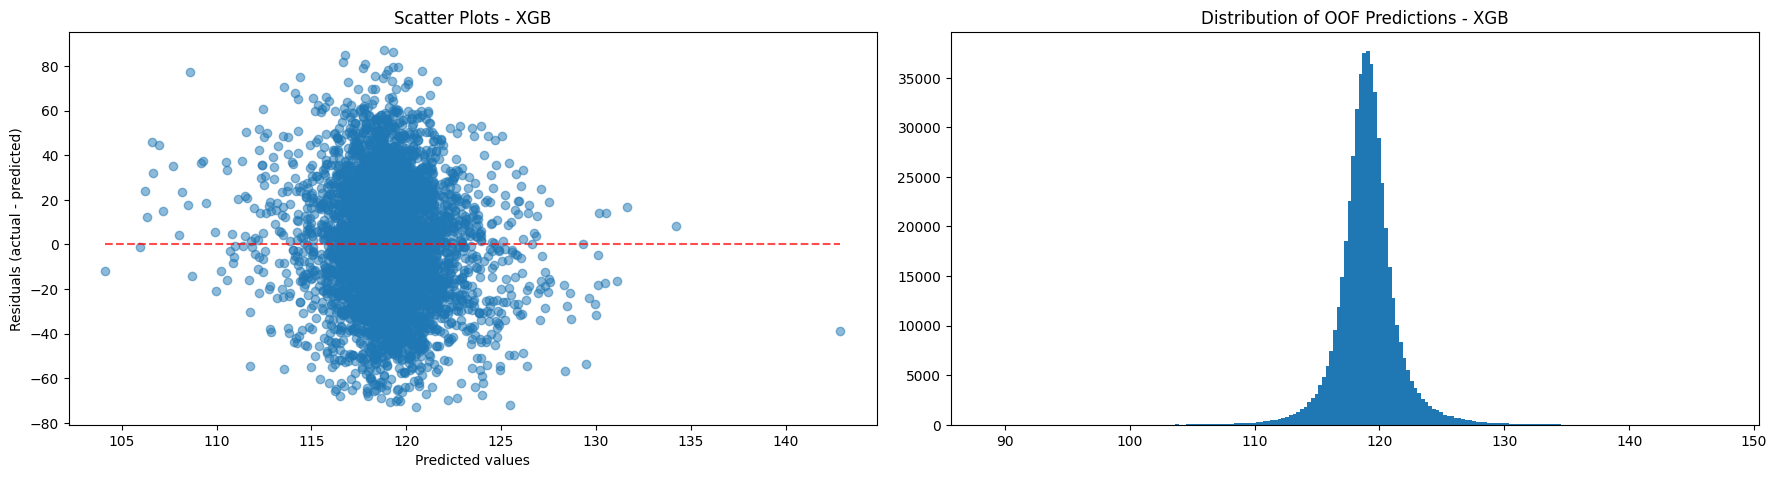

Computation Time: 27.83 secs ################################################################################

[2] LGBM ████████████████████████████████████████
	Fold 1 RMSE: 26.443901
	Fold 2 RMSE: 26.448620
	Fold 3 RMSE: 26.517843
	Fold 4 RMSE: 26.464865
	Fold 5 RMSE: 26.527008
	Fold 6 RMSE: 26.530055
	Fold 7 RMSE: 26.449062
	Fold 8 RMSE: 26.445042
	Fold 9 RMSE: 26.407944
	Fold 10 RMSE: 26.417380
|----------------------------------------------------
|  Overall OOF RMSE: 26.465206
| Average Fold RMSE: 26.465172 ± 0.042140


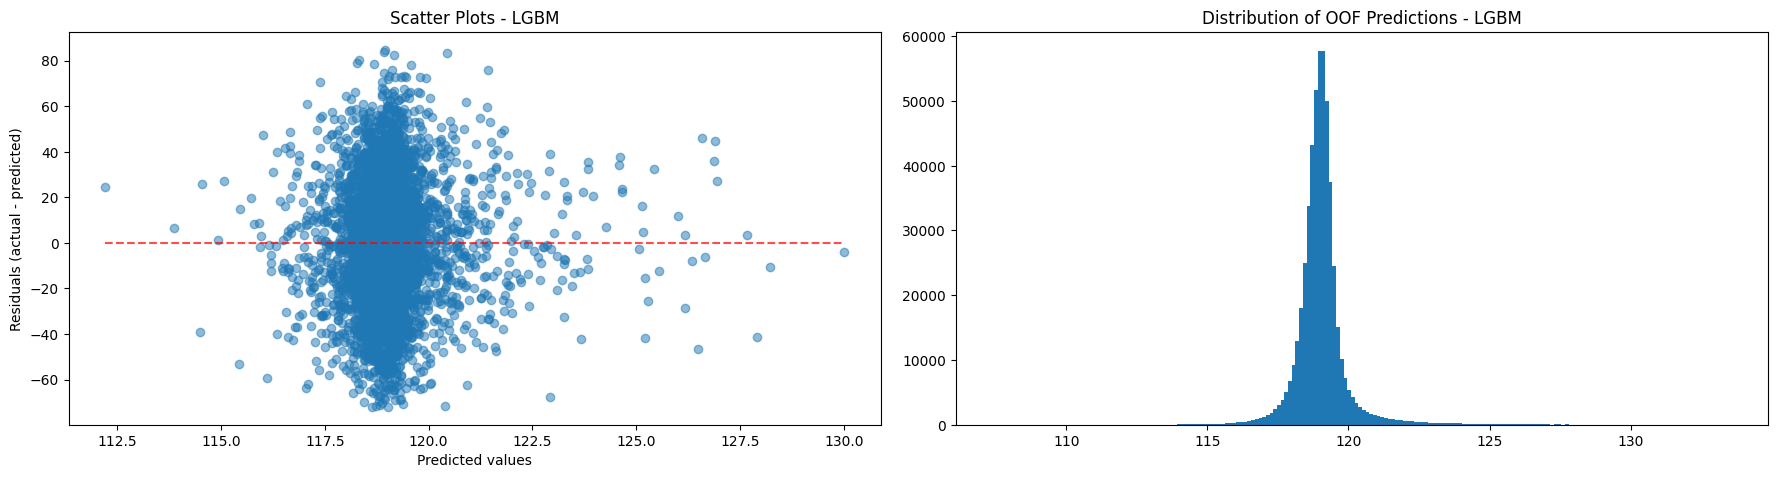

Computation Time: 17.04 secs ################################################################################

[3] CAT ████████████████████████████████████████
	Fold 1 RMSE: 26.435378
	Fold 2 RMSE: 26.442833
	Fold 3 RMSE: 26.514045
	Fold 4 RMSE: 26.455479
	Fold 5 RMSE: 26.521543
	Fold 6 RMSE: 26.523704
	Fold 7 RMSE: 26.445912
	Fold 8 RMSE: 26.444173
	Fold 9 RMSE: 26.402524
	Fold 10 RMSE: 26.415639
|----------------------------------------------------
|  Overall OOF RMSE: 26.460156
| Average Fold RMSE: 26.460123 ± 0.041723


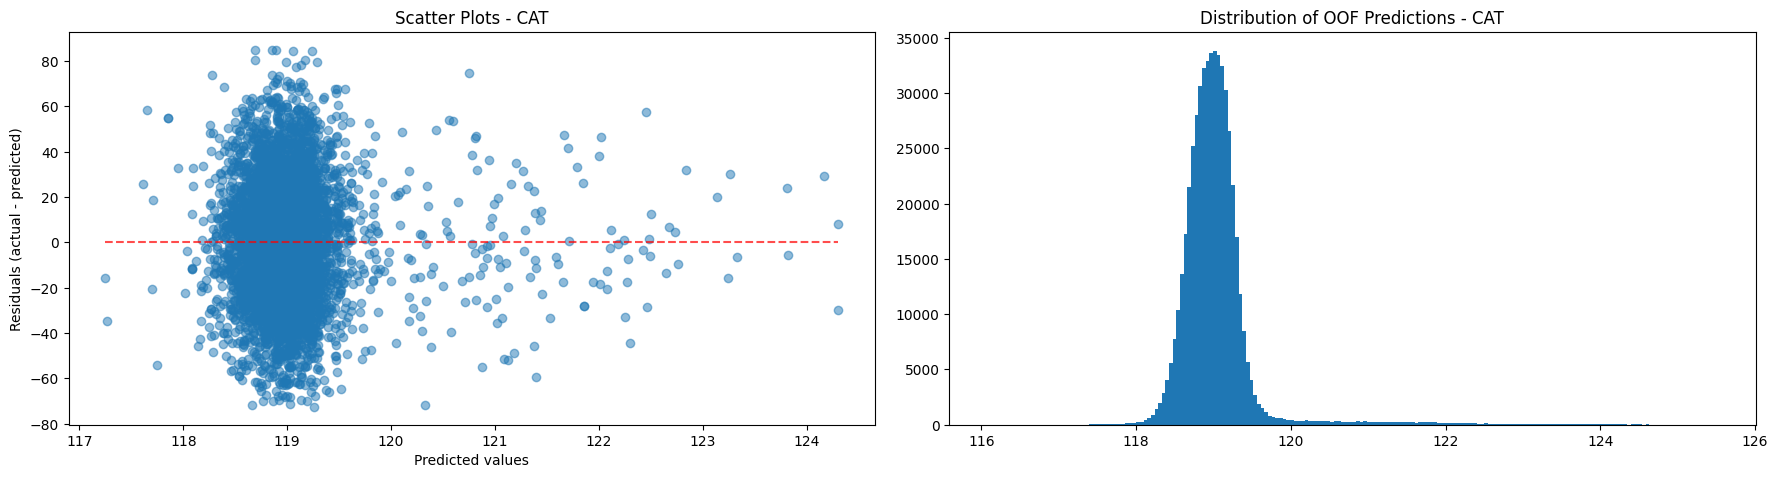

Computation Time: 38.08 secs ################################################################################

[4] HGB ████████████████████████████████████████
	Fold 1 RMSE: 26.433164
	Fold 2 RMSE: 26.443889
	Fold 3 RMSE: 26.517056
	Fold 4 RMSE: 26.454451
	Fold 5 RMSE: 26.522609
	Fold 6 RMSE: 26.526592
	Fold 7 RMSE: 26.446073
	Fold 8 RMSE: 26.441885
	Fold 9 RMSE: 26.403558
	Fold 10 RMSE: 26.416390
|----------------------------------------------------
|  Overall OOF RMSE: 26.460601
| Average Fold RMSE: 26.460567 ± 0.042693


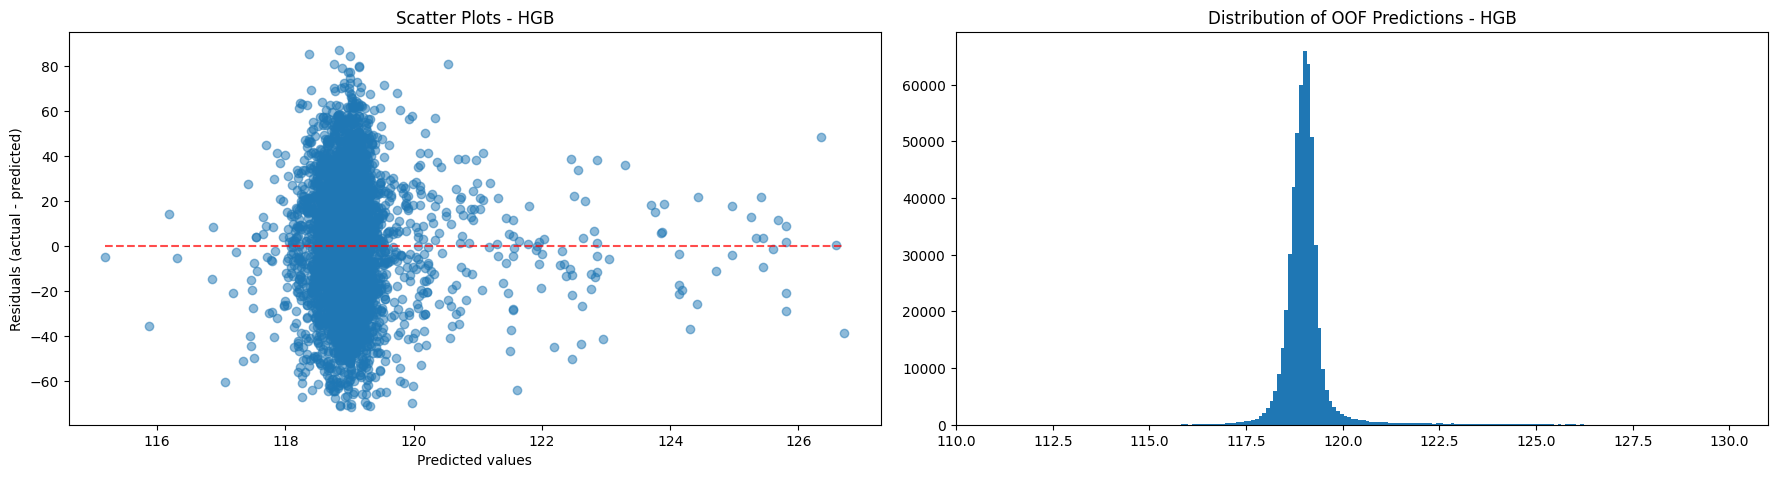

Computation Time: 20.68 secs ################################################################################


In [17]:
## -- DEFINE TRAINING PARAMETERS -- ##
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
## -- Split data --
X = train[FEATURES]
y = train[TARGET]

oof_final_df = pd.DataFrame()
test_final_df = pd.DataFrame()

E_STOP     = 100
FOLDS      = 10
REPEATS    = 2
MODELS_FIT = {}

# kf = RepeatedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)


## -- INITIATE TRAINING -- ##
## -----------------------------------------------------------------------
for i, (name, model) in tqdm(enumerate(models.items(), 1), total=len(models), desc="TRAINING MODELS"):
    print(f"\n[{i}] {COLOR}{name} {'█'*40}{RESET}")
    tik = time()

    oof_preds  = np.zeros(len(X))
    test_preds = np.zeros(len(test))
    fold_RMSEs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
        model.fit(X_train_fold, y_train_fold,
                  # early_stopping_rounds=E_STOP,
                  # eval_set=[(X_val_fold, y_val_fold)],
                  # verbose=200,
            )
        y_fold_pred = model.predict(X_val_fold)
        oof_preds[val_idx] = y_fold_pred

        # Predict on test set (accumulate final prediction)
        test_proba = model.predict(test)
        test_preds += test_proba / FOLDS #* REPEATS

        # Compute RMSE for validation fold
        fold_rmse = rmse(y_val_fold, y_fold_pred)
        fold_RMSEs.append(fold_rmse)

        print(f"\tFold {fold} RMSE: {fold_rmse:.6f}")

    ## -- After all folds:
    overall_RMSE = rmse(y, oof_preds)
    print(f"|{'-'*52}")
    print(f"{COLOR}|  Overall OOF RMSE: {overall_RMSE:.6f}")
    print(f"| Average Fold RMSE: {np.mean(fold_RMSEs):.6f} ± {np.std(fold_RMSEs):.6f}{RESET}")
    ## -- Plot ROC CURVE --
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))
    display = PredictionErrorDisplay.from_predictions(
                        y, oof_preds, ax=axs[0],
                        # kind="actual_vs_predicted",
                        subsample=5000,
                        scatter_kwargs={"alpha": 0.5},
                        line_kwargs={'color': 'r'},
                    )
    axs[0].set_title(f"Scatter Plots - {name}")
    # -----------------------------------------------------
    axs[1].hist(oof_preds, bins=200)
    axs[1].set_title(f"Distribution of OOF Predictions - {name}") 
    # -----------------------------------------------------
    for ax in axs: ax.grid(False)
    fig.tight_layout(pad=1.5) 
    plt.show()

    oof_final_df[name]  = oof_preds
    test_final_df[name] = test_preds
    MODELS_FIT[name]    = model

    tok = time()
    tiktok = tok-tik
    print(f"Computation Time: {tiktok:.2f} secs {'#'*80}")

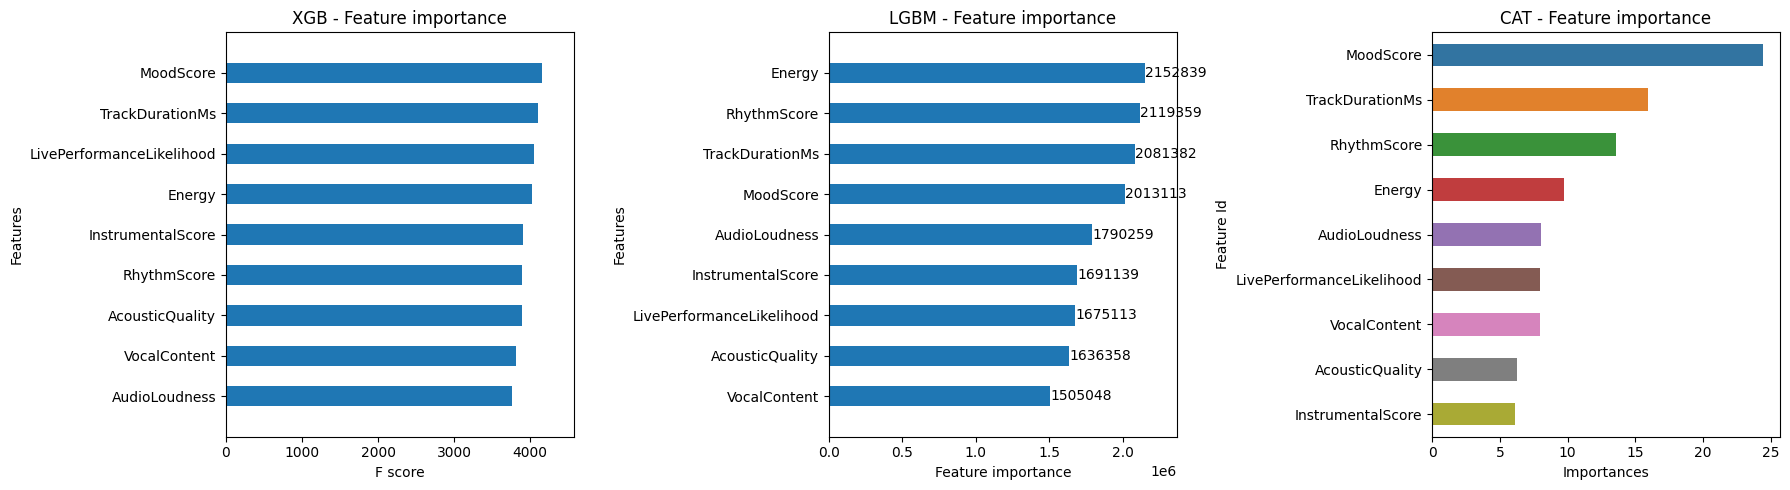

In [18]:
## -- PLOT FEATURES IMPORTANCES -- 
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

## -- XGBoost -- 
xgb.plot_importance(MODELS_FIT['XGB'], importance_type='gain',
                    ax=axs[0], grid=False, height=.5, show_values=False,
                    title="XGB - Feature importance")

## -- LightGBM -- 
lgb.plot_importance(MODELS_FIT['LGBM'], importance_type='gain',
                    ax=axs[1], grid=False, height=.5, precision=0,
                    title="LGBM - Feature importance")

## -- CatBoost -- 
cat_imp_df = MODELS_FIT['CAT'].get_feature_importance(prettified=True)
sns.barplot(data=cat_imp_df, x='Importances', y='Feature Id', width=.5, ax=axs[2])
axs[2].set_title('CAT - Feature importance')

plt.tight_layout()
plt.show()

100%|===================| 4995/5000 [00:18<00:00]       

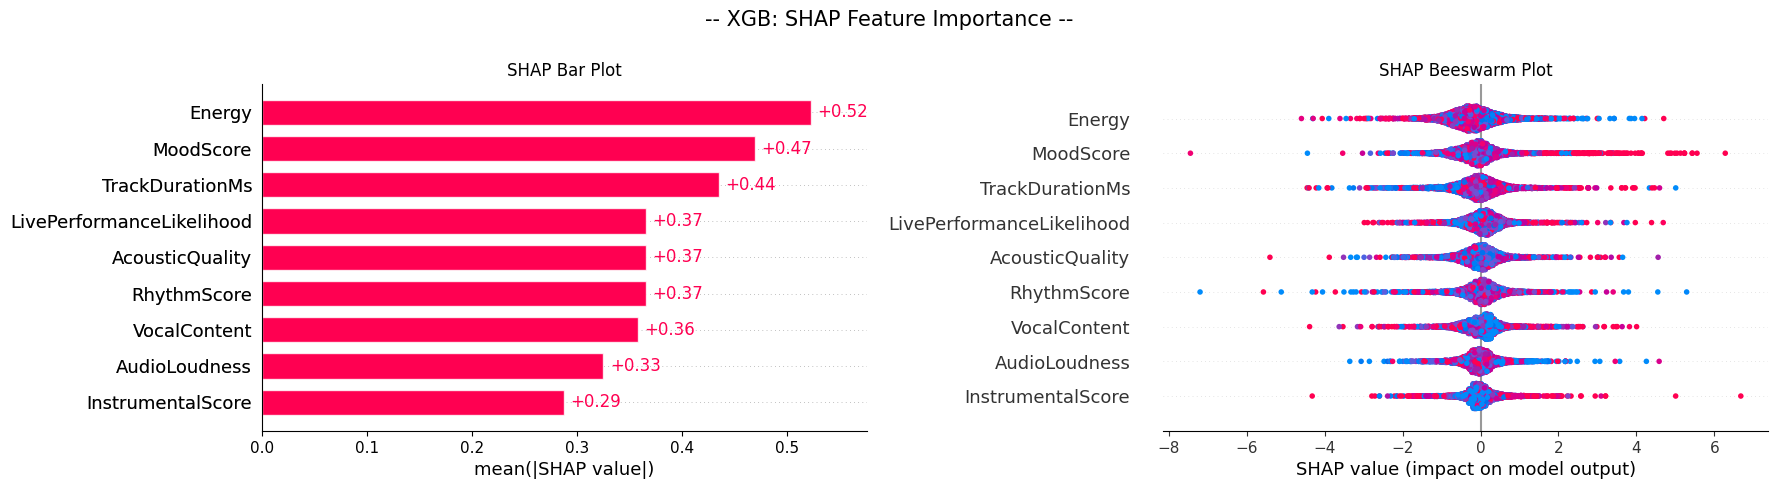

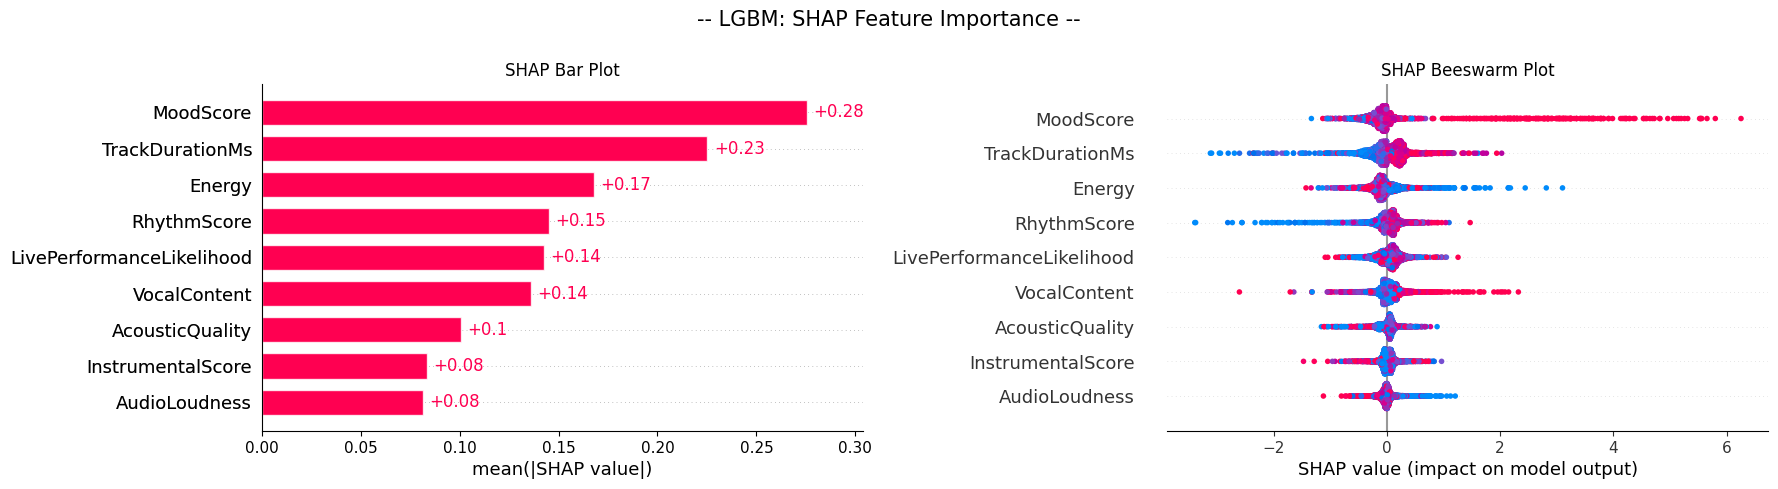

 99%|===================| 4974/5000 [00:27<00:00]       

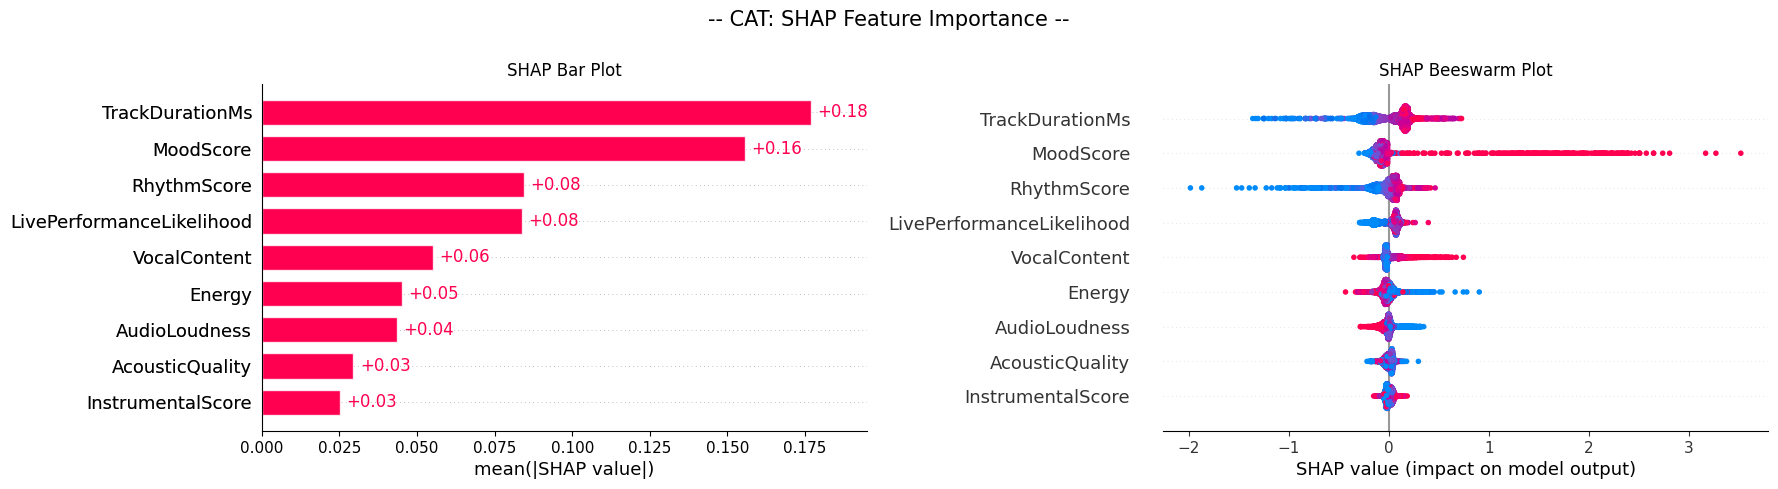

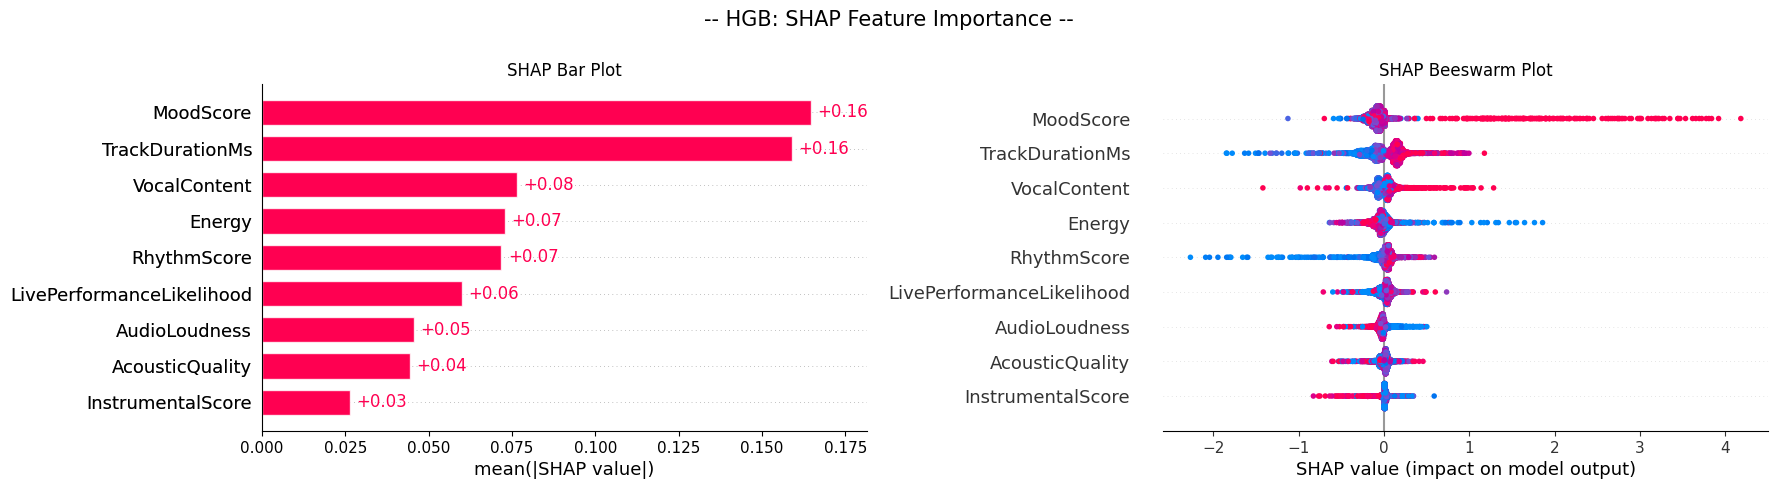

In [19]:
## -- Plot SHAP values --
for i, (name, model) in enumerate(MODELS_FIT.items()):
    fig, axs = plt.subplots(1, 2, figsize=(18, 5))
    
    explainer = shap.TreeExplainer(model, X_train_fold)
    shap_values = explainer(X_val_fold.sample(5000))
    
    # Bar plot on first subplot
    shap.plots.bar(shap_values, show=False, ax=axs[0])
    axs[0].set_title("SHAP Bar Plot")
    
    # Beeswarm plot on second subplot
    shap.plots.beeswarm(shap_values, show=False, ax=axs[1], color_bar=False, plot_size=None)
    axs[1].set_title("SHAP Beeswarm Plot") 
    
    # Add suptitle and adjust layout
    fig.suptitle(f"-- {name}: SHAP Feature Importance --", fontsize=15)
    fig.tight_layout(pad=1.5) 
    
    plt.show()
    print("\n")